In [19]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Import Requirements

In [20]:
import re
import numpy as np
import pandas as pd
import nltk
import keras
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Embedding, Bidirectional, GRU, GlobalAveragePooling1D, Dropout, Dense


import warnings
warnings.filterwarnings("ignore")

# Download NLTK stopwords
nltk.download('stopwords')

# Set options for pandas display
pd.options.display.max_colwidth = 1000
pd.options.display.max_rows  = 100
pd.set_option("display.min_rows", 200)

# Set up early stopping callback
early_stopping = EarlyStopping(mode='min', patience=5)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Dataset

In [21]:
train = pd.read_csv("E:/Ruhama's Project/Coronavirus tweets NLP/Corona_NLP_train.csv",encoding='latin-1')
train_data = train[["OriginalTweet","Sentiment"]]

In [22]:
print("Ccunt Of Labels : {} ".format(train_data.Sentiment.value_counts().to_dict()))
print("Total number of Labels : {}".format(len(train_data.Sentiment.unique())))

Ccunt Of Labels : {'Positive': 11422, 'Negative': 9917, 'Neutral': 7713, 'Extremely Positive': 6624, 'Extremely Negative': 5481} 
Total number of Labels : 5


# Preprocessing

In [23]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return "Positive"
    elif sentiment == "Extremely Negative":
        return "Negative"
    elif sentiment == "Negative":
        return "Negative"
    elif sentiment == "Positive":
        return "Positive"
    else:
        return "Neutral"

In [24]:
train_data['Sentiment'] = train_data['Sentiment'].apply(lambda x : change_sen(x))

count_dict = train_data['Sentiment'].value_counts().to_dict()
Labels = list(count_dict.keys())
values = list(count_dict.values())


In [25]:
px.pie(values = values,names = Labels,hole=.5,title = "Label Counts In Percentage")

In [26]:
stop_words = stopwords.words('english')
train_data["OriginalTweet"]  = train_data['OriginalTweet'].apply(lambda x:x.lower())

In [27]:
def clean_data(text):
    text = str(text).strip()
    text = text.replace("?","")
    text = re.sub(r"http\S+","",text)
    text = re.sub(r"@\w+","",text)
    text = re.sub(r"#\w+","",text)
    text = re.sub(r"\d+","",text)
    text = re.sub(r"<.*?>","",text)
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])
    #text - str(text).strip()
    return text

In [28]:
train_data["OriginalTweet"] = train_data['OriginalTweet'].apply(lambda x : clean_data(x))

In [29]:
train_data['Sentiment'].unique()
l = dict()
for idx,lbl in enumerate(train_data['Sentiment'].unique()):
    l[lbl] = idx 
    
train_data['Sentiment'] = train_data['Sentiment'].map(l)

max_len = np.max(train_data['OriginalTweet'].apply(lambda x : len(x)))

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, GRU, GlobalAveragePooling1D, Dropout, Dense

# Assuming you have your data loaded and preprocessed, including train_data and test_data

# Split the data into train and test sets
train, test = train_test_split(train_data, test_size=0.3)


# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train["OriginalTweet"])
vocab_length = len(tokenizer.word_index) + 1

# Convert text data to sequences and pad them
max_len = 100  # Specify the maximum sequence length
x_train = pad_sequences(tokenizer.texts_to_sequences(train["OriginalTweet"]), maxlen=max_len)
x_test = pad_sequences(tokenizer.texts_to_sequences(test["OriginalTweet"]), maxlen=max_len)

# Convert sentiment labels to categorical format
y_train = to_categorical(train["Sentiment"], num_classes=3)
y_test = to_categorical(test["Sentiment"], num_classes=3)

# Define the model architecture
embedding_dim = 16
model = Sequential([
    Embedding(vocab_length, embedding_dim, input_length=max_len),
    Bidirectional(GRU(64, return_sequences=True)),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(16, activation='relu', activity_regularizer='l2'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
num_epochs = 10
history = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           482176    
                                                                 
 bidirectional_4 (Bidirecti  (None, 100, 128)          31488     
 onal)                                                           
                                                                 
 global_average_pooling1d_4  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 16)                2064      
                                                                 
 dropout_9 (Dropout)         (None, 16)               

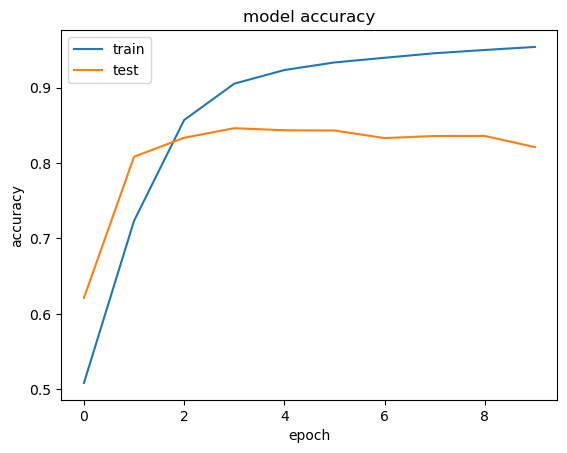

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

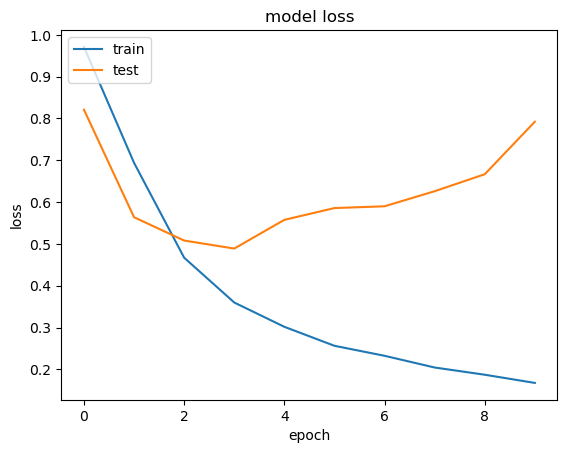

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

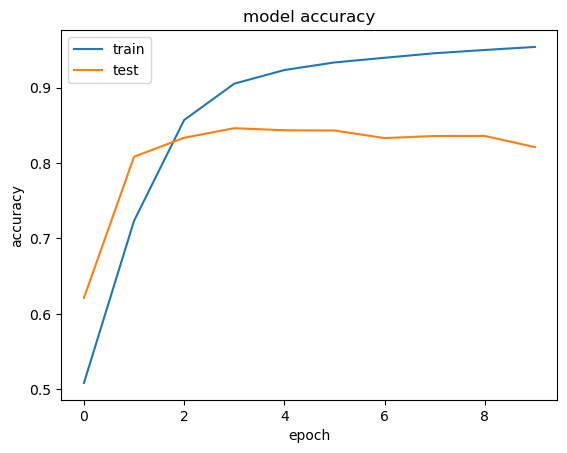

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

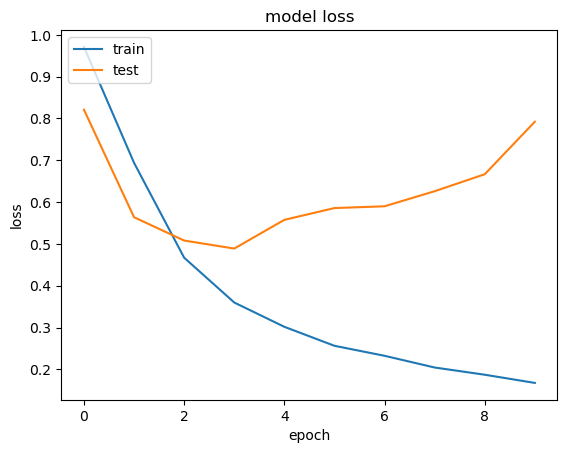

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## LSTM


In [40]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length,embedding_dim,input_length = max_len),
    tf.keras.layers.LSTM(256,return_sequences = True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16,activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3,activation = 'softmax')
])

In [41]:
model_1.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [42]:
num_epochs = 100
history = model_1.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test),callbacks=[early_stopping])

Epoch 1/100
901/901 [==============================] - 138s 150ms/step - loss: 0.9935 - accuracy: 0.4698 - val_loss: 0.8477 - val_accuracy: 0.6400
Epoch 2/100
901/901 [==============================] - 163s 181ms/step - loss: 0.7667 - accuracy: 0.6794 - val_loss: 0.6566 - val_accuracy: 0.7434
Epoch 3/100
901/901 [==============================] - 166s 185ms/step - loss: 0.5437 - accuracy: 0.8087 - val_loss: 0.5286 - val_accuracy: 0.8034
Epoch 4/100
901/901 [==============================] - 170s 188ms/step - loss: 0.4495 - accuracy: 0.8517 - val_loss: 0.5006 - val_accuracy: 0.8150
Epoch 5/100
901/901 [==============================] - 165s 184ms/step - loss: 0.3309 - accuracy: 0.8975 - val_loss: 0.5061 - val_accuracy: 0.8176
Epoch 6/100
901/901 [==============================] - 150s 167ms/step - loss: 0.2793 - accuracy: 0.9142 - val_loss: 0.5784 - val_accuracy: 0.8138
Epoch 7/100
901/901 [==============================] - 159s 177ms/step - loss: 0.2391 - accuracy: 0.9244 - val_loss: 0

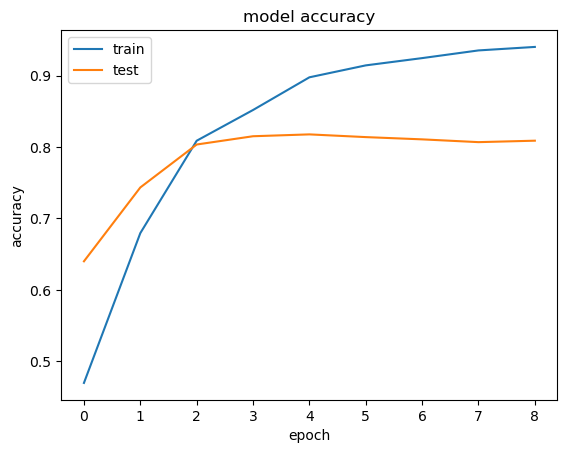

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

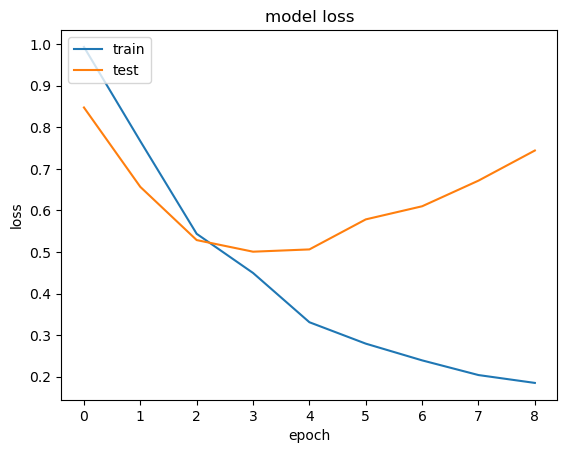

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()